# PySPPL: Introduction

Python SPPL is a probabilsitic programming langauge that is built for enabling one to perform inference in probabilistic programs that require gradient based inference algorihtms. As `if-else` statements within probabilistic programs that use gradient based inference, take on two different forms. On one hand hand `if-else` have the usual programmer interpretation, but on the other, when random variables are placed inside of the predicate, or the body of an `if-else` expression, then we must treat those variables with care as discontinuities arise at point of indecision. We must ensure that at this indecision boundary that the discontinuity, with respect to space it is in and the measure imposed on it, has a measure of zero. 

Our framework was built to ensure that certain criteria in the compiled output of a directed acyclic graphical model are met. The language is extensible enough for one to add their own custom built potentials; which could be either log joint densities or loss functions, within the framework. There is a higher layer inference framework that takes advantage of PySPPL called [pyfo](https://github.com/bradleygramhansen/pyfo), we are actively developing this. The corresponding paper is called [Discontinuous Hamiltonian Monte Carlo for Probabilistic Programs](https://arxiv.org/abs/1804.03523). 

In this walkthrough we shall go through the basics of how to write a model and how to compile the model. In the following walkthrough we shall show how to use custom density functions, how add other distributions within the framework and how to take advantage of the translation rules that are embedded within the language. 

## PySPPL imports

In [1]:
%matplotlib inline
from pyppl import compile_model 
from pyppl.utils.core import create_network_graph, display_graph


## A statistical model with basic control-flow

For fun, let us add some contextual data: Whether or not Alice decides to go to space is highly dependedent upon the number points Alice collects, which is dependent upon a draw from a centered normal distribution, $x_1$. If she draws a number greater than 0, then we observe that Alice gets 1.5 points and the likelihood she goes to space, given the 1.5 points is distributed by $\mathcal{N}(1.5~|~x_1,1)$. However, if she draws a number less than or equal to 0, then her likelihood is quite different. She gains 1 point, but the likelihood that the distribution is centered around 1, is dependedent upon a random draw from a categorical distrubtion that spits out 0 with probability 0.1, 1 with probability 0.2, and 2 with probability 0.7. If we find that the value of the $x_1$ after the inference is greater than zero, then Alice goes to space, else she stays on Earth :-(


$$ x_1 \sim \mathcal{N}(0,1) $$
$$ x_2 \sim \mathcal{Cat}(0.1, 0.2, 0.7) $$
we observe our data ("points")
$$y_1 = 1.5 $$
$$y_2 = 1 $$

likelihood terms
$$ y_1 = 1.5~|~x_1 = \mathcal{N}(y_1~|~x_1,~1) $$
$$ y_2 = 1~|~x_2 = \mathcal{N}(y_2~|~x_2,~1) $$


In [34]:
model_if_clojure="""
(let [x1 (sample (normal 0 1))
      x2 (sample (categorical [0.1 0.2 0.7]))
      y1 1.5
      y2 1]
  (if (> x1 0)
    (observe (normal x1 1) y1)
    (observe (normal x2 1) y2))
  [x1 x2])
"""


compiled_clojure = compile_model(model_if_clojure, language='clojure')


The compiler takes the above code and transforms it into a model class, from which the user can manipulate the program and interface with an inference engine. 

Here is a print out of the model class for the above model:

In [3]:
print(compiled_clojure.code)

# 2018-06-18 09:42:24.644173
import torch
import torch.distributions as dist


class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_ve

We can change the models imported by changing the arguements in the `compile_model` function. By specification to our current application the compiler automatically imports `pytorch`. This can be easily removed by going into `ppl_graph_codegen.py` file and then removing the `if not has_dist` block. 

In [38]:
compile_clojure = compile_model(model_if_clojure, language='clojure',imports='import matplotlib as mpl \nimport numpy as np ')
print(compile_clojure.code[:121])

# 2018-06-18 09:55:22.261447
import torch
import torch.distributions as dist
import matplotlib as mpl 
import numpy as np


## Printing the Graph G(V,E) of the statistical model. 

Each vertex of the graph is an object, with a set of attributes. These attributes describe the relationships between the vertex and other vertices. In addition to this, the attributes contain information about the observables and latent variables at each vertex.


In [48]:
print(compile_clojure)

#Vertices: 4, #Arcs: 2
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'loc': '0', 'scale': '1'}
  Dist-Code:      dist.Normal(0, 1)
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
Vertex x30002 [Sample]
  Name:           x30002
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'probs': '[0.1, 0.2, 0.7]'}
  Dist-Code:      dist.Categorical([0.1, 0.2, 0.7])
  Dist-Name:      Categorical
  Dist-Type:      DistributionType.DISCRETE
  Sample-Size:    1
Vertex y30004 [Observe]
  Name:           y30004
  Ancestors:      x30001
  Conditions:     cond_30003=True
  Cond-Ancs.:     x30001
  Cond-Nodes:     cond_30003
  Dist-Args:      {'loc': "state['x30001']", 'scale': '1'}
  Dist-Code:      dist.Normal(state['x30001'], 1)
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Observation:    1.5
Vertex y30005 [Observe]
  Name:           y3

We can see from the graph that $x_2$ is only dependent on the observation $y_2$, whereas $x_1$ can be affected by both observations. 

##  An example of an independent Categorical model

The below model is completely impratical as a statistical model. It is purely here to show what happens when every variable in the model is independent.

In [40]:
model_categorical = """
(let[z (sample (categorical [0.7 0.15 0.15]))
    z1 (sample (categorical [0.1 0.5 0.4]))
    z2 (sample (categorical [0.2 0.2 0.6]))]
    z z1 z2)"""

In [49]:
compiled_clojure = compile_model(model_categorical, language='clojure')
# print(compiled_clojure.code)
vertices = compiled_clojure.vertices

### Plotting the depndence graph

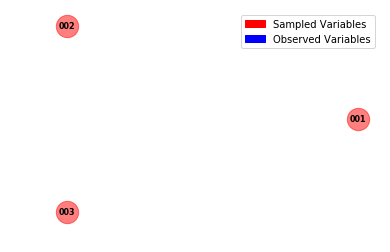

In [50]:
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

As you can see, in this model there are no dependencies between the different latent variables.

## A Hidden Markov Model

In [51]:
model_hmm_clojure="""
(defn data [n]
  (let [points (vector 0.9 0.8 0.7 0.0 -0.025
                       5.0 2.0 0.1 0.0 0.13
                       0.45 6.0 0.2 0.3 -1.0 -1.0)]
    (get points n)))

;; Define the init, transition, and observation distributions
(defn get-init-params []
  (vector (/ 1. 3.) (/ 1. 3.) (/ 1. 3.)))

(defn get-trans-params [k]
  (nth (vector (vector 0.1  0.5  0.4 )
               (vector 0.2  0.2  0.6 )
               (vector 0.7 0.15 0.15 )) k))

(defn get-obs-dist [k]
  (nth (vector (normal -1. 1.)
               (normal  1. 1.)
               (normal  0. 1.)) k))

;; Function to step through HMM and sample latent state
(defn hmm-step [n states]
  (let [next-state (sample (categorical (get-trans-params (last states))))]
    (observe (get-obs-dist next-state) (data n))
    (conj states next-state)))

;; Loop through the data
(let [init-state (sample (categorical (get-init-params)))]
  (loop 16 (vector init-state) hmm-step))

"""

### Plotting the graphical model

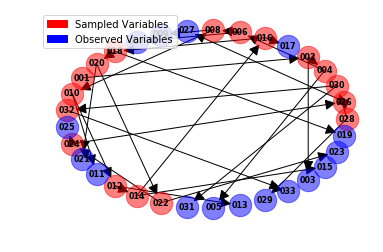

In [52]:
compiled_clojure = compile_model(model_hmm_clojure, language='clojure')
vertices = compiled_clojure.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

# PySPPL for python based models

PySPPLs design allows one to use it with many different langauges, we so far have built an interface for both `python` and `clojure` code. 


## Bayesian linear regression model

$$slope \sim \mathcal{N}(0, 10) $$
$$bias \sim \mathcal{N}(0, 10) $$

Observations
$$y = [(1.,2.), (2.1,3.9), (3.,5.3)] $$
Constructing the equation of the predicted curve
$$z_n = slope \times y[0,:] + bias$$
The likelihood
$$y = y[1,:]~|~z_n = \mathcal{N}(y[1,:]~|~z_n,~\mathbf{I}) $$   

## The python SPPL code

In [53]:
model_lr_python = """import torch
slope = sample(normal(torch.tensor(0.0), torch.tensor(10.0)))
bias  = sample(normal(torch.tensor(0.0), torch.tensor(10.0)))
y  = torch.tensor([[1.0, 2.1], [2.0, 3.9], [3.0, 5.3]])
zn = slope*data[:,0] + bias # y  = mx + c
observe(normal(zn, torch.ones(len(zn))),data[:,1])

[slope, bias]
"""

compiled_python = compile_model(model_lr_python, language='python')

## The Graph


In [54]:
print(compiled_python)

#Vertices: 3, #Arcs: 2
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'loc': 'torch.tensor(0.0)', 'scale': 'torch.tensor(10.0)'}
  Dist-Code:      dist.Normal(torch.tensor(0.0), torch.tensor(10.0))
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     slope
Vertex x30002 [Sample]
  Name:           x30002
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'loc': 'torch.tensor(0.0)', 'scale': 'torch.tensor(10.0)'}
  Dist-Code:      dist.Normal(torch.tensor(0.0), torch.tensor(10.0))
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     bias
Vertex y30003 [Observe]
  Name:           y30003
  Ancestors:      x30002, x30001
  Conditions:     
  Cond-Ancs.:     
  Cond-Nodes:     
  Dist-Args:      {'loc': "((state['x30001'] * state['data'][:,0]) + state['x30002'])", 'scale': "torch.ones(len(((state['x30001'] 

## The dependency graph

With `python` models we can plot the user defined label names. 

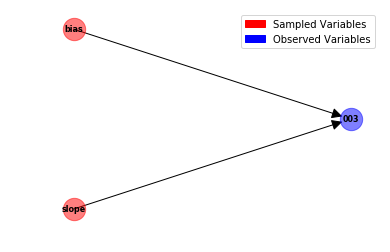

In [55]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

# Models in pure python
We don't need to import `torch`, we can actually write models in pure python, for example:

In [56]:
model_purepython="""mean = sample(poisson(3))
x= sample(gamma(mean,1))
y= 10
observe(normal(x,5), y)
"""
compiled_python = compile_model(model_purepython, language='python')

## An Example of the Graph G(V,E)

In [57]:
print(compiled_python)

#Vertices: 3, #Arcs: 2
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'lam': '3'}
  Dist-Code:      dist.Poisson(3)
  Dist-Name:      Poisson
  Dist-Type:      DistributionType.DISCRETE
  Sample-Size:    1
  Orig. Name:     mean
Vertex x30002 [Sample]
  Name:           x30002
  Ancestors:      x30001
  Cond-Ancs.:     
  Dist-Args:      {'alpha': "state['x30001']", 'beta': '1'}
  Dist-Code:      dist.Gamma(state['x30001'], 1)
  Dist-Name:      Gamma
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     x
Vertex y30003 [Observe]
  Name:           y30003
  Ancestors:      x30002
  Conditions:     
  Cond-Ancs.:     
  Cond-Nodes:     
  Dist-Args:      {'loc': "state['x30002']", 'scale': '5'}
  Dist-Code:      dist.Normal(state['x30002'], 5)
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Observation:    10
Arcs A:
  (x30001, x30002), (x30002, y

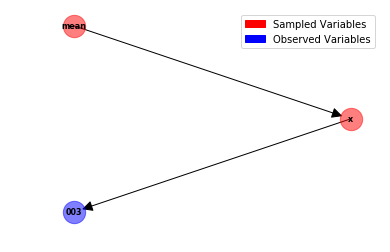

In [58]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

## Gaussian Mixture model

In [59]:
model_gmm2 = """
import torch

means  = 2
samples  = 10
y = [-2.0, -2.5, -1.7, -1.9, -2.2, 1.5, 2.2, 3.0, 1.2, 2.8,
      -1.7, -1.3,  3.2,  0.8, -0.9, 0.3, 1.4, 2.1, 0.8, 1.9] 
ys = torch.tensor([y])
pi = torch.tensor(0.5*torch.ones(samples,means))
mus = sample(normal(torch.zeros(means,1), 2*torch.ones(means,1)))

zn = sample(categorical(pi), sample_size=2)

for i in range(samples):
    index = (zn == i).nonzero()
    observe(normal(mus[i]*torch.ones(len(index),1), 2*torch.ones(len(index),1)), ys[index])
"""

compiled_python = compile_model(model_gmm2, language='python')

## The code output

In [36]:
print(compiled_python.code)

# 2018-06-15 08:40:37.239078
import torch
import torch.distributions as dist
import torch

class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.u

## The dependency graph

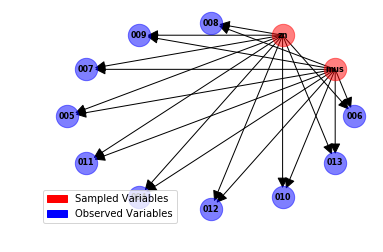

In [60]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

## Coal Minining

In [64]:
model_coal_mining="""
e = sample(exponential(1))
l = sample(exponential(1))
T = 112
s = sample(uniform(0,10))
y = [4,5,4,1,0,4,3,4,0,6,3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,
      3,4,2,5,2,2,3,4,2,1,3,2,1,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,
      0,3,2,2,0,1,1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,2,3,1,1,
      2,1,1,1,1,2,4,2,0,0,0,1,4,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0]
for i in range(T-1):
    if i+1 < s:
        observe(exponential(e), y[i])
    else:
        observe(exponential(1), y[i])
[e,l,s]
"""
compiled_python = compile_model(model_coal_mining, language='python')


## The code output

In [67]:
print(compiled_python)

#Vertices: 225, #Arcs: 111
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'rate': '1'}
  Dist-Code:      dist.Exponential(1)
  Dist-Name:      Exponential
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     e
Vertex x30002 [Sample]
  Name:           x30002
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'rate': '1'}
  Dist-Code:      dist.Exponential(1)
  Dist-Name:      Exponential
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     l
Vertex x30003 [Sample]
  Name:           x30003
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'a': '0', 'b': '10'}
  Dist-Code:      dist.Uniform(0, 10)
  Dist-Name:      Uniform
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     s
Vertex y30005 [Observe]
  Name:           y30005
  Ancestors:      x30001
  Conditions:     cond_30004=True
  Cond-Ancs.:     x30003
  Cond-N

## The dependency graph

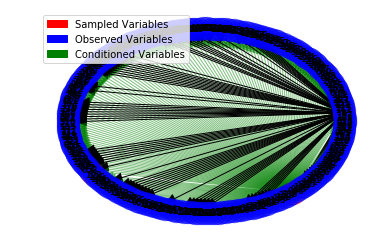

In [66]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);